# Zillow 2017 Predictions
<br>

### Project Goals  
- Discover drivers of Single Family home value for Zillow in 2017.
- Use drivers to develop a machine learning model that accurately predicts home value
- This information could be used for furture years in helping Zillow achieve max profit

In [66]:
# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistical/mathmatical imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from math import sqrt
import os
# ML imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Premade functions
from acquire import get_zillow_data
from wrangle import wrangle_zillow
from wrangle import scale_data
#Removes big scary warnings
import warnings
warnings.filterwarnings('ignore')

# Acquire
<BR></BR>
- Data aquired from SQL zillow database  
- It contained 52441 rows and 6 columns before cleaning  
- Each row represents a house  
- Each column represents a feature associated with the house  

In [2]:
# use acquire function to import messy data
df = get_zillow_data()

In [31]:
# lets take a peak
df.head(1)

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
0,5,4.0,2148,165392,10408,1976


In [4]:
# look into info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   yearbuilt                     52325 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


In [5]:
# get a feel for shape
df.shape

(52441, 6)

# Prepare
<BR>

- Renamed colums to read easier on the eyes  
- Checked for nulls in the data and dropped said nulls  
- Checked that column data types were appropriate and had to change as necessary  
- Got rid of outliers that skewed the data 
- Split data into train, validate and test, stratifying on 'tax_value'  

In [ ]:
# Import prepare function to clean data 

# Quick peak into the cleaned data
df.head()

In [6]:
#change column names to be more readable
df = df.rename(columns={'bedroomcnt':'bedrooms', 
                        'bathroomcnt':'bathrooms', 
                        'calculatedfinishedsquarefeet':'house_sqft',
                        'taxvaluedollarcnt':'tax_value', 
                        'lotsizesquarefeet':'lot_size_sqft',
                        'yearbuilt':'year_built'
                        })

In [7]:
# describe df while you're at it
df.describe()

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
count,52441.000000,52441.000000,52359.000000,5.244000e+04,5.207200e+04,52325.000000
mean,3.300681,2.299403,1922.890754,5.296882e+05,1.133962e+04,1963.393884
std,0.949094,1.022772,1004.365838,7.518946e+05,8.674763e+04,23.133571
min,0.000000,0.000000,128.000000,1.000000e+03,2.360000e+02,1878.000000
25%,3.000000,2.000000,1268.000000,1.937475e+05,5.583000e+03,1950.000000
50%,3.000000,2.000000,1659.000000,3.736120e+05,6.840500e+03,1961.000000
75%,4.000000,3.000000,2306.000000,6.193012e+05,8.798250e+03,1979.000000
max,14.000000,18.000000,21929.000000,4.906124e+07,6.971010e+06,2016.000000


In [8]:
# drop nulls pls 
df = df.dropna()

In [9]:
# drop duplicates and inplace is to make it firm to this notebook
df.drop_duplicates(inplace=True)

In [10]:
# change some data types to ints as some don's need to be floats
df["lot_size_sqft"] = df["lot_size_sqft"].astype(int)
df["year_built"] = df["year_built"].astype(int)
df["bedrooms"] = df["bedrooms"].astype(int)    
df["tax_value"] = df["tax_value"].astype(int)
df["house_sqft"] = df["house_sqft"].astype(int)

In [11]:
# make sure our code is working with checking the head
df.head()

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
0,5,4.0,2148,165392,10408,1976
1,4,3.0,2982,1066369,435641,1983
2,2,1.0,1080,62874,112560,1960
3,2,2.0,1407,272678,7079,1937
4,3,2.0,1372,241195,5799,1978


In [12]:
df.bedrooms.value_counts(ascending=True)

11        1
10        2
9         8
8        24
0        54
7       103
1       577
6       626
5      3910
2      8238
4     15081
3     23203
Name: bedrooms, dtype: int64

In [13]:
df.bathrooms.value_counts(ascending=True)

13.0        1
8.5         2
11.0        3
10.0        5
9.0        12
7.5        16
0.0        41
6.5        47
8.0        52
7.0        87
5.5       224
6.0       300
4.5       681
5.0       773
1.5       824
3.5       909
4.0      2158
2.5      3923
1.0      9471
3.0     10537
2.0     21761
Name: bathrooms, dtype: int64

In [14]:
df.describe()[['house_sqft','lot_size_sqft']]

,house_sqft,lot_size_sqft
count,51827.000000,5.182700e+04
mean,1918.863257,1.122751e+04
std,994.852023,8.661604e+04
min,128.000000,2.360000e+02
25%,1268.000000,5.583000e+03
50%,1657.000000,6.840000e+03
75%,2301.000000,8.781000e+03
max,21929.000000,6.971010e+06


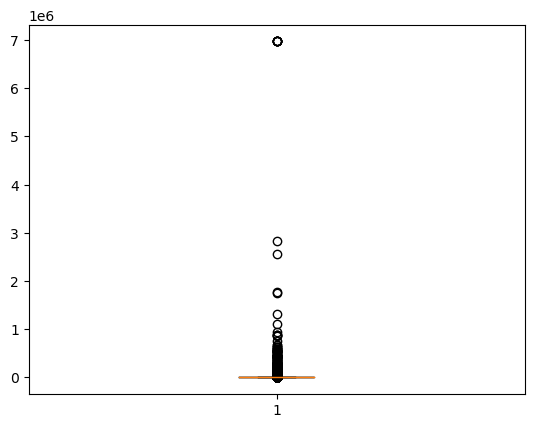

In [15]:
plt.boxplot(df.lot_size_sqft)
plt.show()

In [29]:
#fig = px.histogram(df, x='lot_size_sqft')

#fig.show()

In [28]:
#fig = px.histogram(df, x='lot_size_sqft')

#fig.show()

In [27]:
#fig = px.scatter(df, x='lot_size_sqft')

#fig.show()

In [26]:
#fig = px.scatter_matrix(df)

#fig.show()

In [25]:

#fig = px.scatter(df, x="bedrooms", y="bathrooms", color="tax_value", marginal_y="violin",
#           marginal_x="box", trendline="ols", template="simple_white")
#fig.show()

In [24]:
#fig = px.scatter(df, x="house_sqft", y="lot_size_sqft", color="tax_value", marginal_y="violin",
           #marginal_x="box", trendline="ols", template="simple_white")
#fig.show()

# Split data into train/validate/test sample dataframes
<br>

- 20% test, 80% train_validate  
- Then of the 80% train_validate: 30% validate, 70% train     


In [ ]:
# splitting data into train, validate, and test
train, val, test = wrangle_zillow()
# lets see the shape of these
train.shape, val.shape, test.shape

# Explore 
<br>

- Here we will dive into the data and see what pops out to us using visuals  
- Once we get some findings, we will confirm these findings with statistical tests 


In [33]:
df.head()

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
0,5,4.0,2148,165392,10408,1976
1,4,3.0,2982,1066369,435641,1983
2,2,1.0,1080,62874,112560,1960
3,2,2.0,1407,272678,7079,1937
4,3,2.0,1372,241195,5799,1978


bedrooms


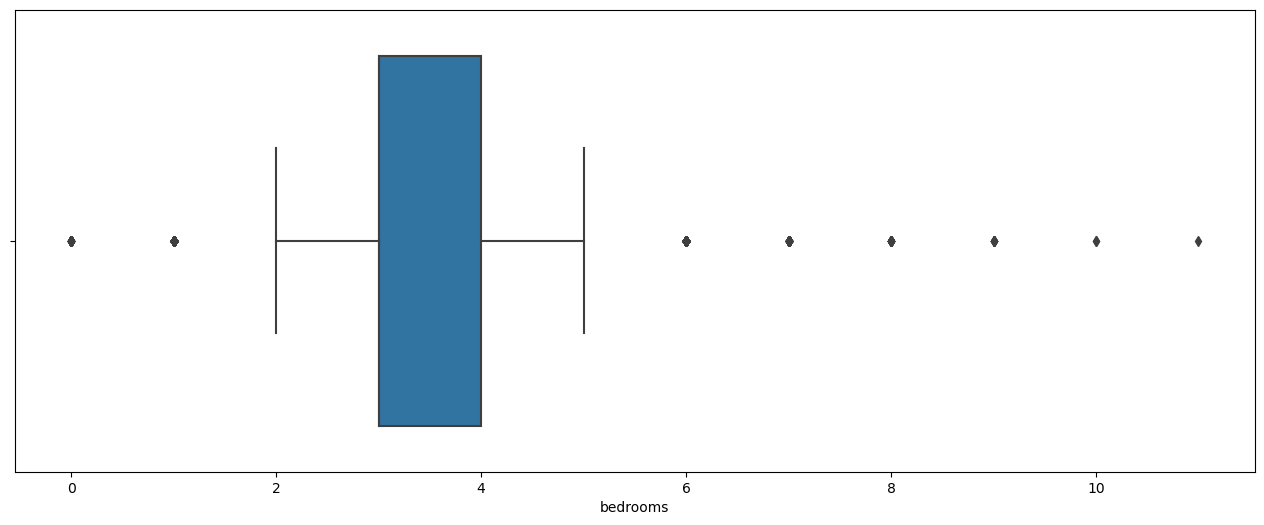

bathrooms


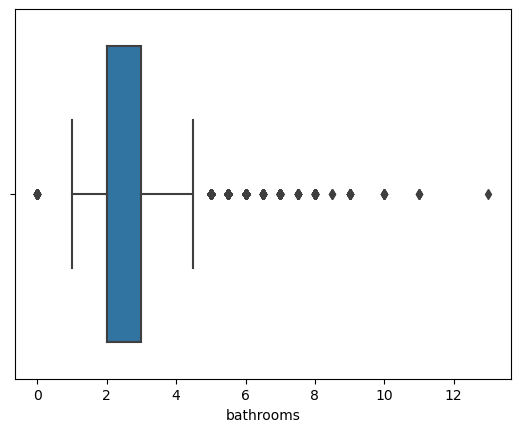

house_sqft


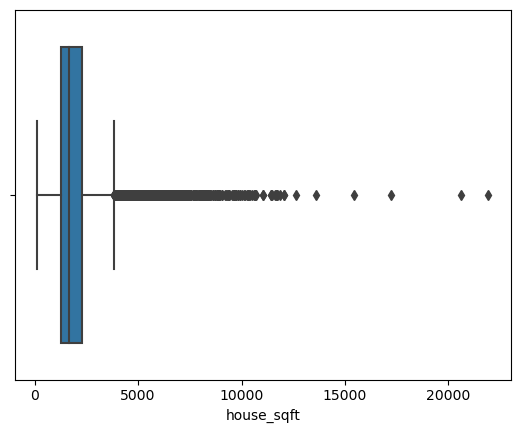

tax_value


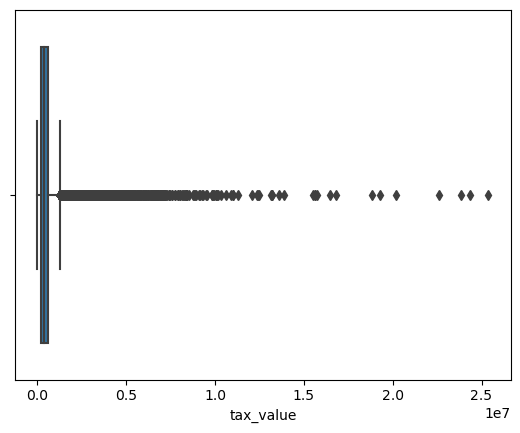

lot_size_sqft


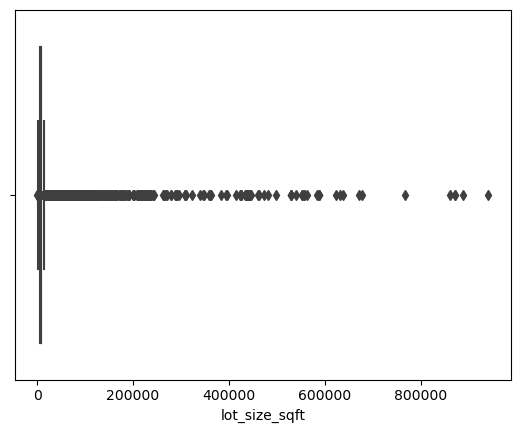

year_built


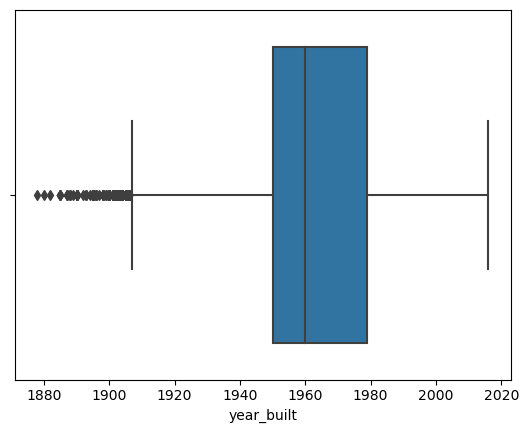

In [42]:
# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['bedrooms', 'bathrooms', 'house_sqft', 'tax_value', 'lot_size_sqft','year_built']

for col in cols:
    print(col)
    sns.boxplot(x=col, data=df)
    plt.show()

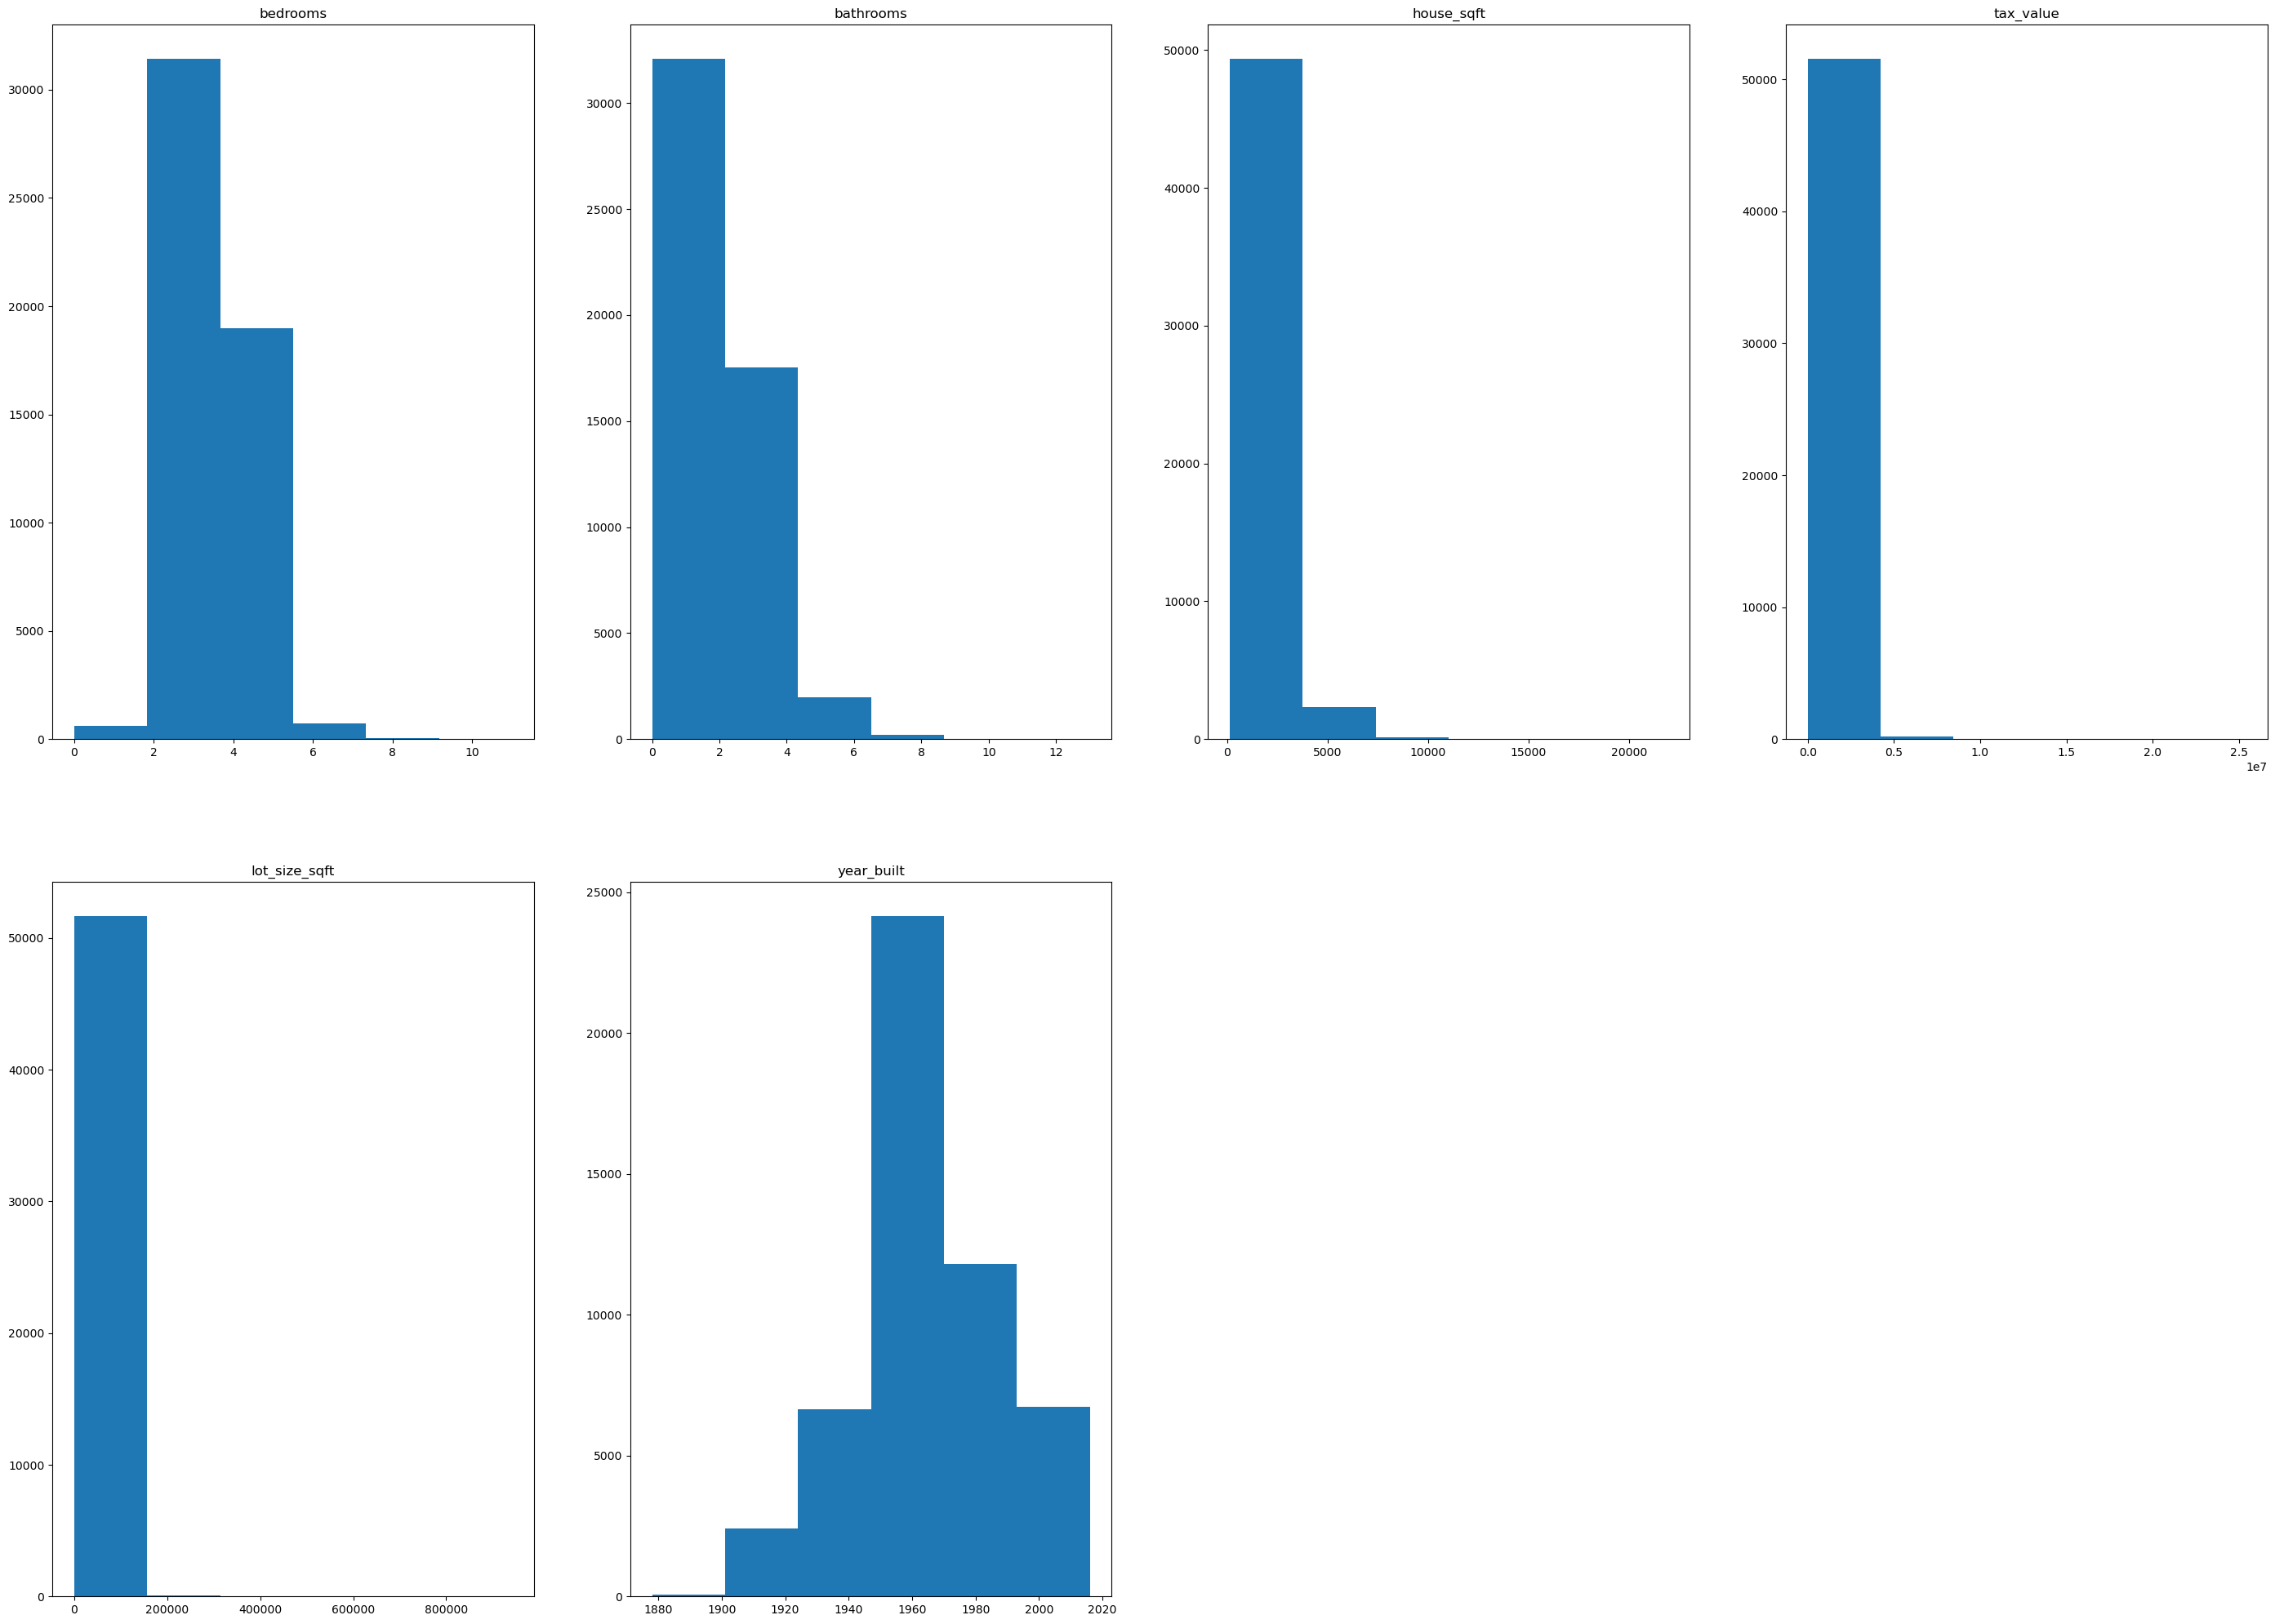

In [46]:
plt.figure(figsize=(35, 25))

# List of columns
cols = ['bedrooms', 'bathrooms', 'house_sqft', 'tax_value', 'lot_size_sqft','year_built']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=6)

    # Hide gridlines.
    plt.grid(False)

In [110]:
# get rid of outliers
df = df[df.bathrooms <= 6]
df = df[df.bedrooms <= 6]
df = df[df.tax_value < 1100000]
df = df[df.house_sqft < 5000]
df = df[df.lot_size_sqft < 11750]

bedrooms


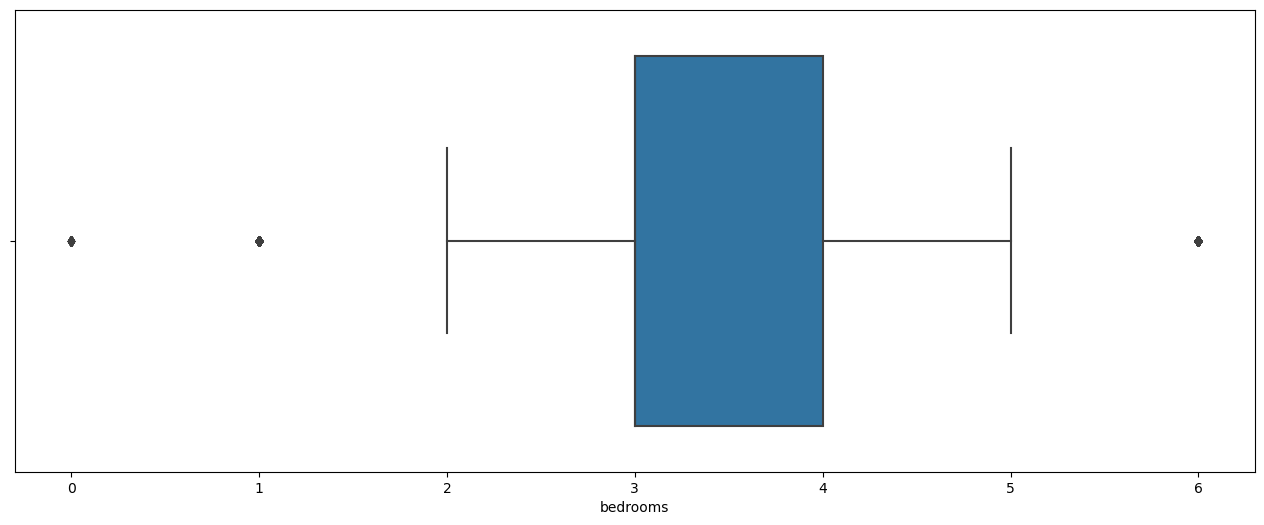

bathrooms


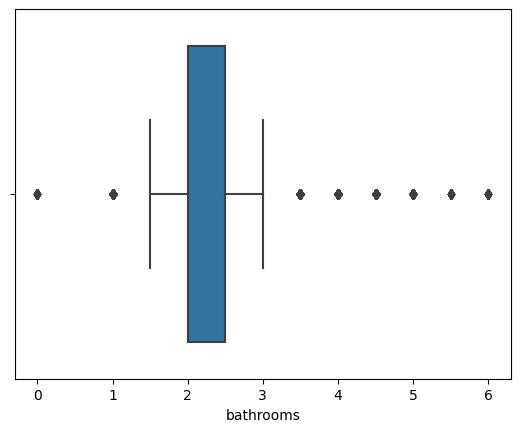

house_sqft


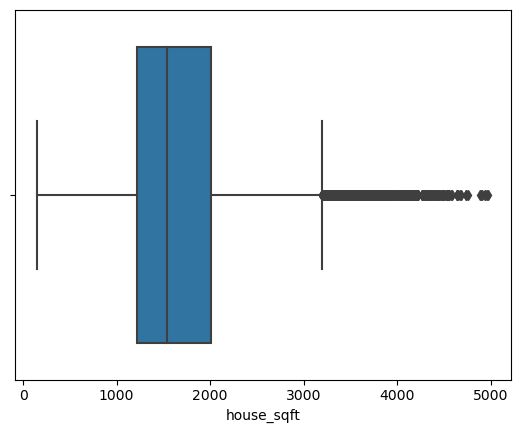

tax_value


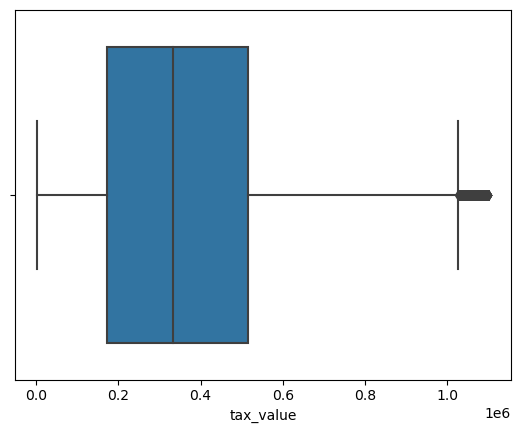

lot_size_sqft


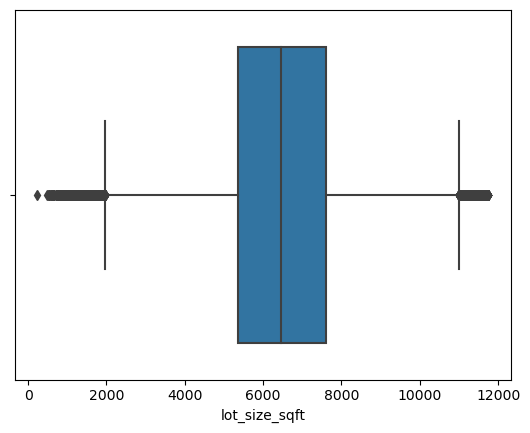

year_built


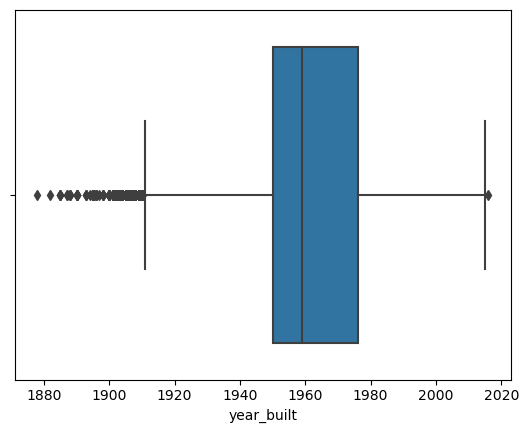

In [111]:
# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['bedrooms', 'bathrooms', 'house_sqft', 'tax_value', 'lot_size_sqft','year_built']

for col in cols:
    print(col)
    sns.boxplot(x=col, data=df)
    plt.show()

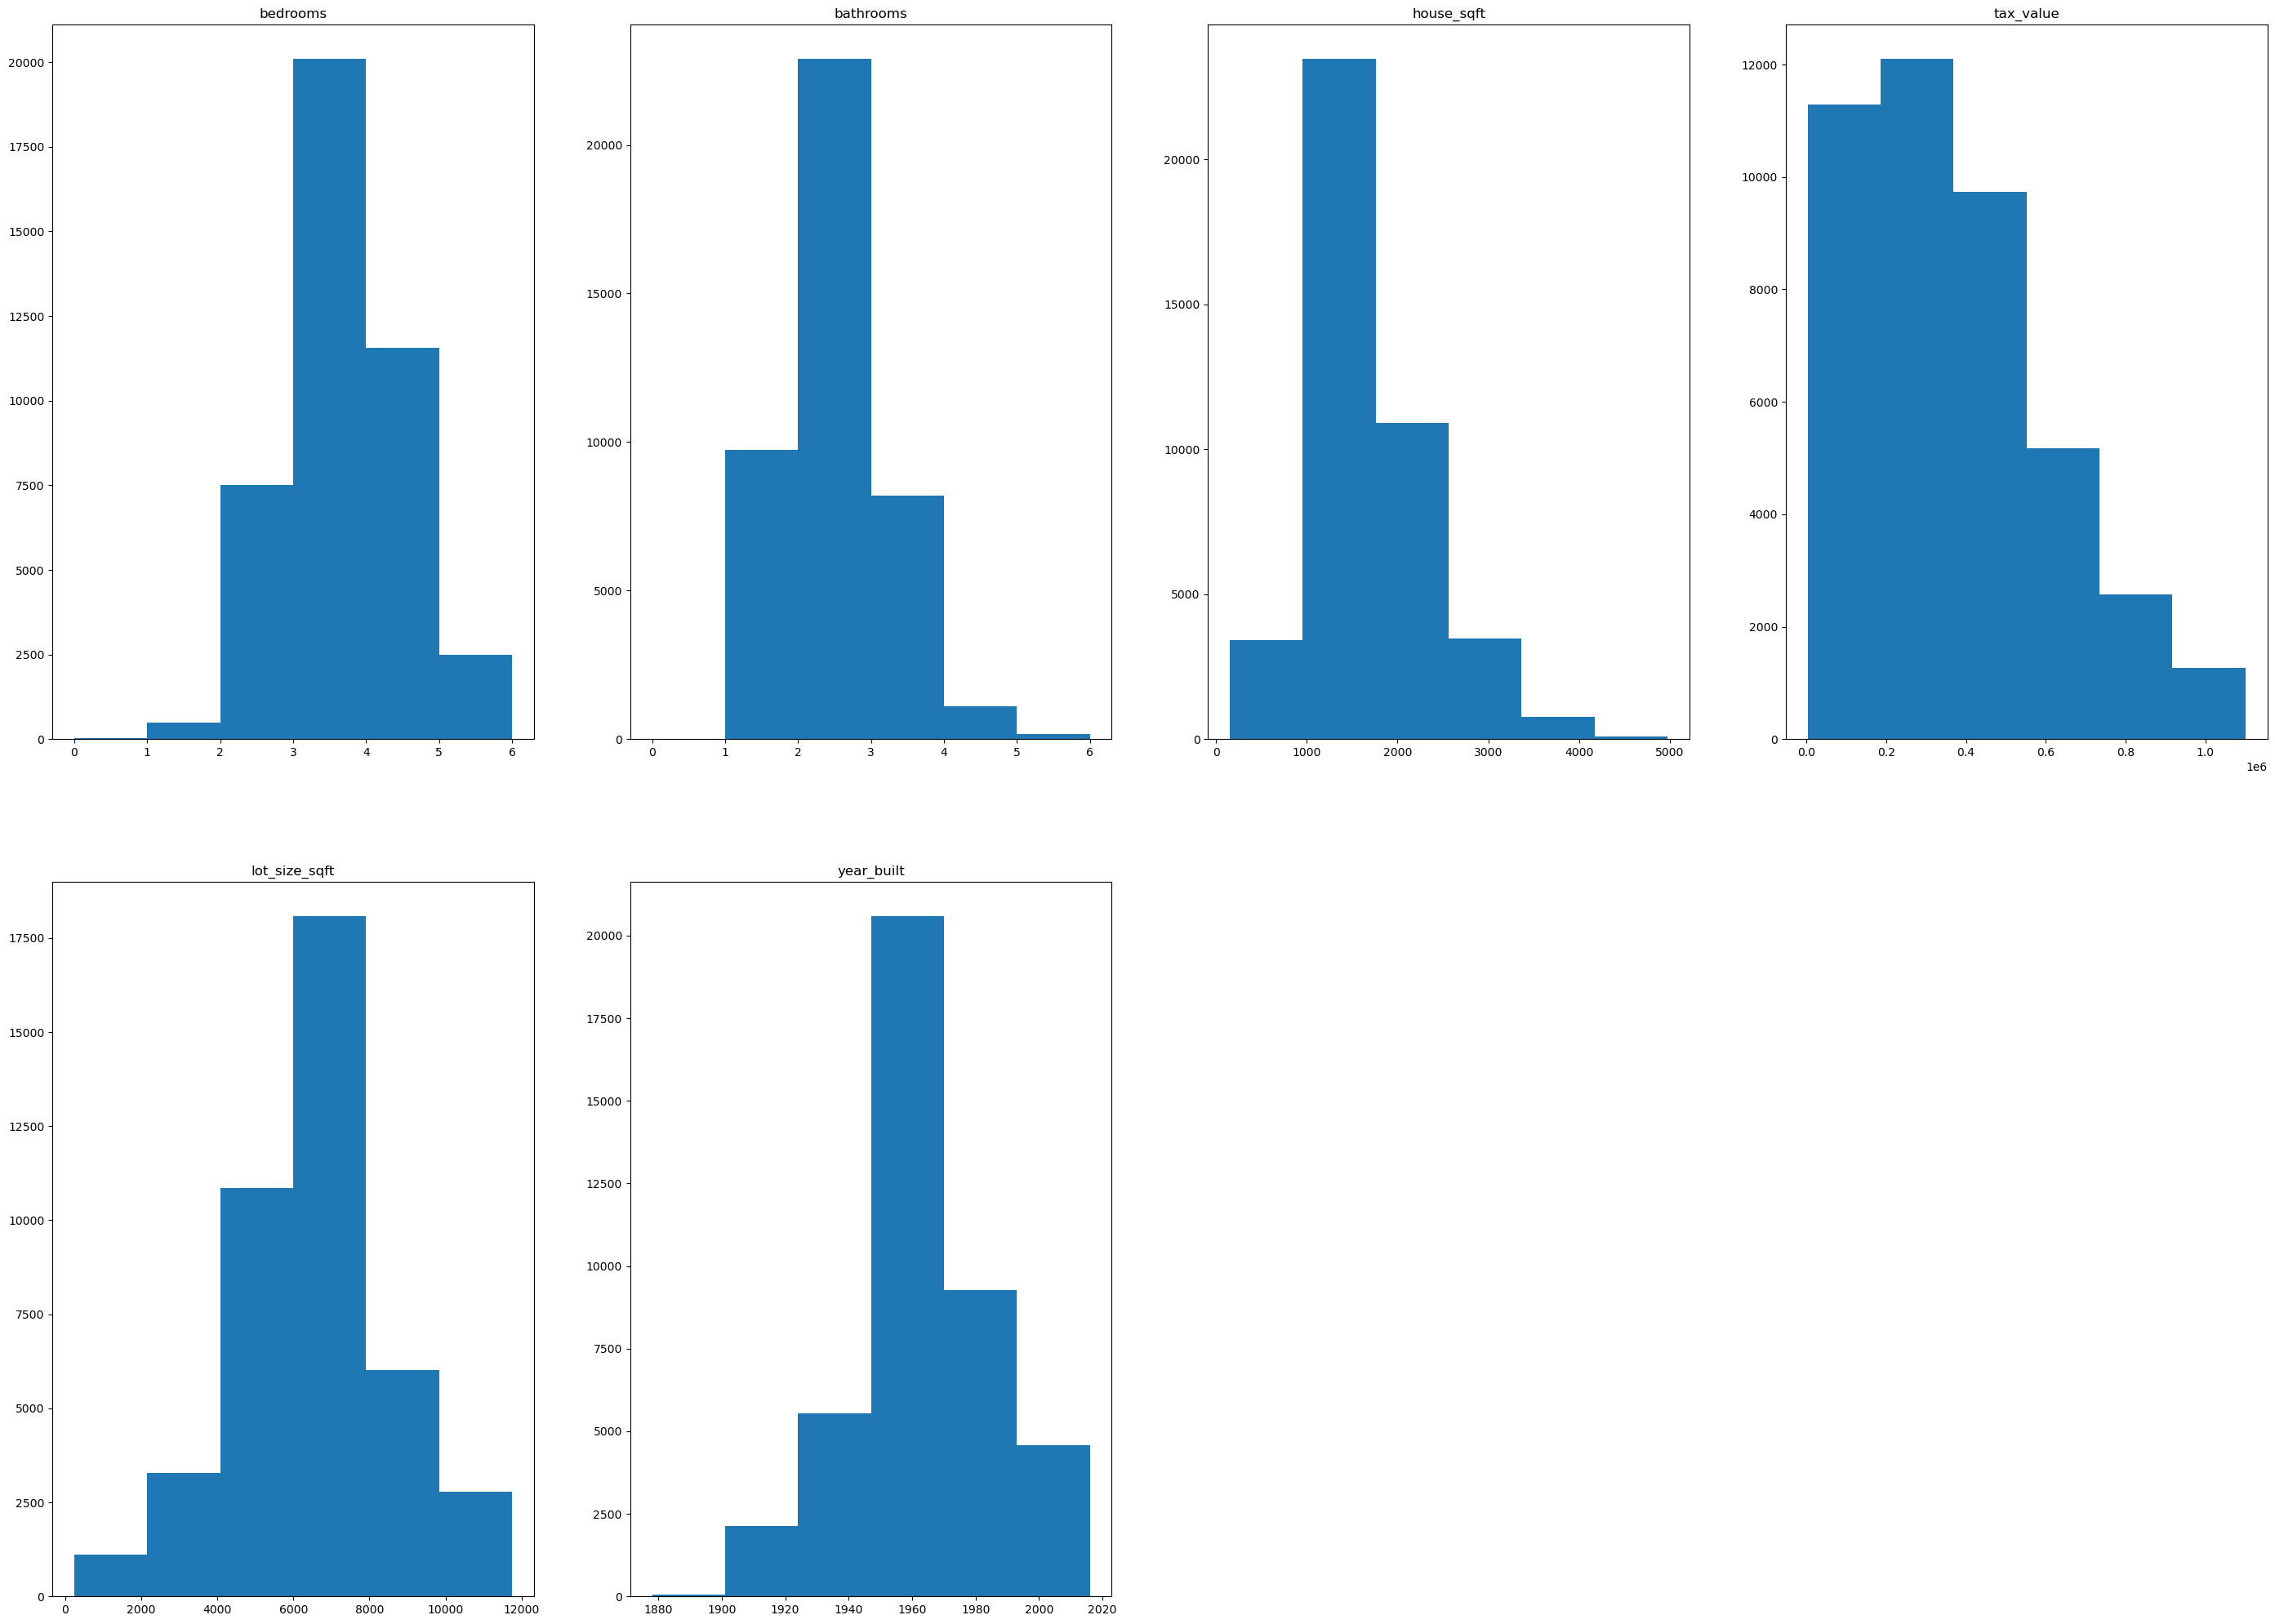

In [112]:
plt.figure(figsize=(35, 25))

# List of columns
cols = ['bedrooms', 'bathrooms', 'house_sqft', 'tax_value', 'lot_size_sqft','year_built']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=6)

    # Hide gridlines.
    plt.grid(False)

In [113]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)


In [114]:
train.shape, validate.shape, test.shape

((23599, 6), (10114, 6), (8429, 6))

In [125]:
#cat_var = ['bedrooms', 'bathrooms']
cont_var = ['house_sqft', 'tax_value', 'lot_size_sqft','year_built','bedrooms', 'bathrooms']

In [134]:
def plot_variable_pairs(train, cont_var, cat_var):
    # columns    
    #cat_var = ['bedrooms', 'bathrooms']
    cont_var = ['house_sqft', 'tax_value', 'lot_size_sqft','year_built','bedrooms', 'bathrooms']

    sns.lmplot(x='tax_value', y='house_sqft', data=train.sample(1000), scatter=True)
    plt.show()
    sns.lmplot(x='tax_value', y='year_built', data=train.sample(1000), scatter=True)
    plt.show()
    sns.lmplot(x='tax_value', y='lot_size_sqft', data=train.sample(1000), scatter=True)
    plt.show()
    sns.lmplot(x='tax_value', y='bedrooms', data=train.sample(1000), scatter=True)
    plt.show()
    sns.lmplot(x='tax_value', y='bathrooms', data=train.sample(1000), scatter=True)
    plt.show()
    
    return train, cont_var, cat_var

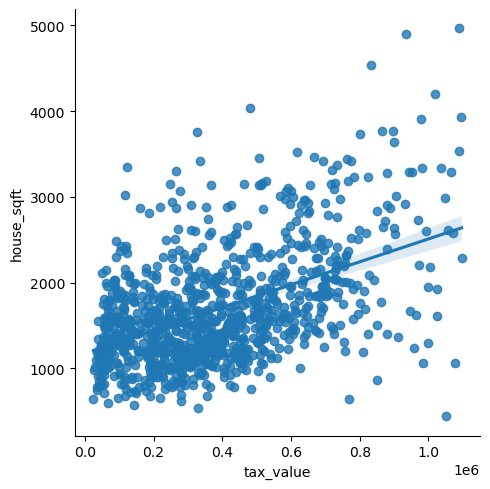

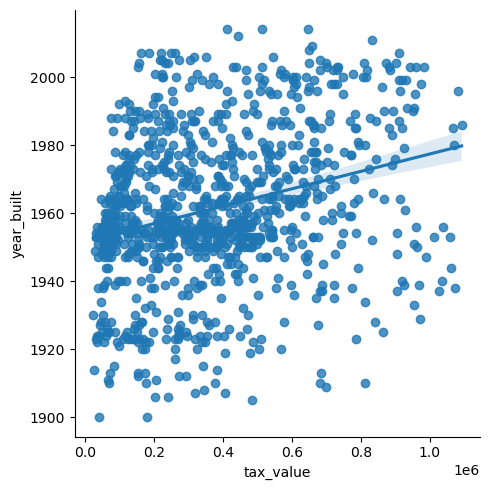

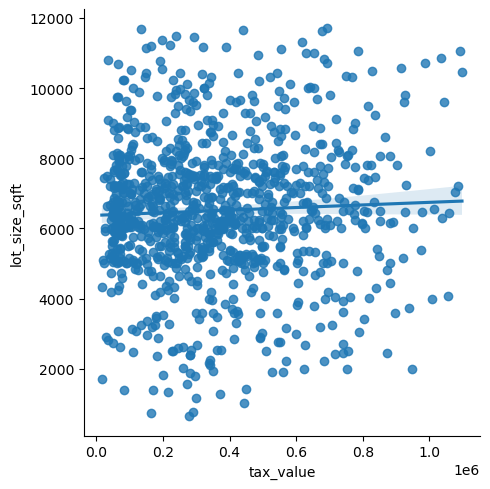

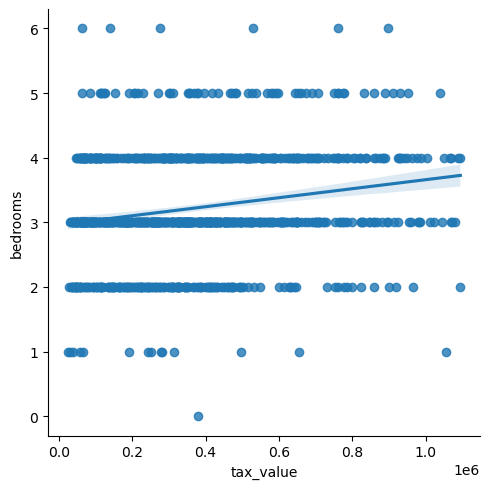

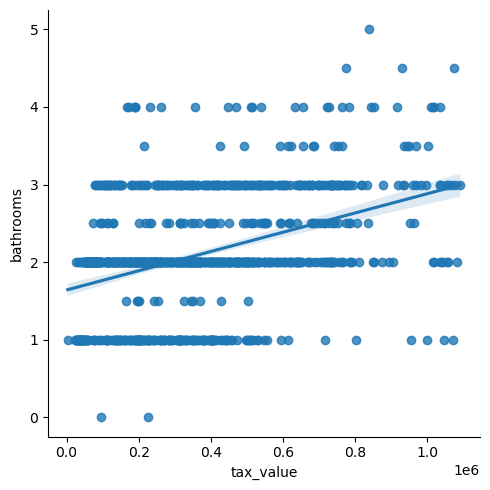

(       bedrooms  bathrooms  house_sqft  tax_value  lot_size_sqft  year_built
 31949         3        2.0        1404     176411           7704        1957
 51617         3        2.0        1456      72444           5369        1954
 42382         3        1.0        1055      64630           6550        1953
 7098          4        1.0        1351      69894           5350        1953
 43253         3        1.0        1010      57978           6365        1961
 ...         ...        ...         ...        ...            ...         ...
 38026         4        2.0        1244     281166           6017        1955
 2377          3        2.0        2040     420000           6016        1953
 46316         3        1.0        1262      50278           5781        1947
 48952         2        1.0        1466      81167           7326        1922
 44172         4        2.0        1197     261538           5892        1961
 
 [23599 rows x 6 columns],
 ['house_sqft',
  'tax_value',
  'l

In [135]:
plot_variable_pairs(train, cont_var, cat_var)

In [118]:
def plot_categorical_and_continuous_vars(train, cont_var, cat_var):
    
    # columns    
    cat_var = ['bedrooms', 'bathrooms']
    cont_var = ['house_sqft', 'tax_value', 'lot_size_sqft','year_built']

    sns.boxplot(x='bedrooms', y='tax_value', data=train.sample(1000))
    plt.show()
    sns.violinplot(x='bathrooms', y='tax_value', data=train.sample(1000))
    plt.show()
    
    return train, cont_var, cat_var

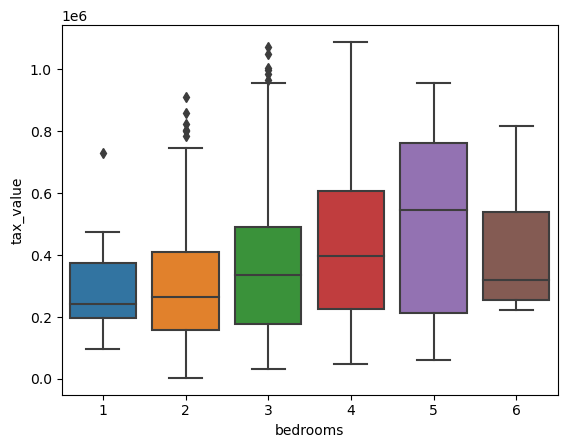

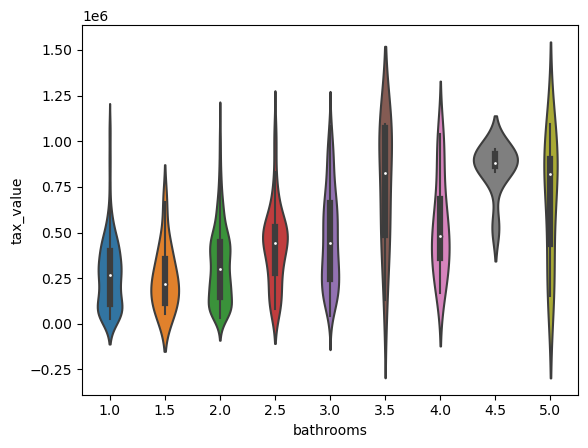

(       bedrooms  bathrooms  house_sqft  tax_value  lot_size_sqft  year_built
 31949         3        2.0        1404     176411           7704        1957
 51617         3        2.0        1456      72444           5369        1954
 42382         3        1.0        1055      64630           6550        1953
 7098          4        1.0        1351      69894           5350        1953
 43253         3        1.0        1010      57978           6365        1961
 ...         ...        ...         ...        ...            ...         ...
 38026         4        2.0        1244     281166           6017        1955
 2377          3        2.0        2040     420000           6016        1953
 46316         3        1.0        1262      50278           5781        1947
 48952         2        1.0        1466      81167           7326        1922
 44172         4        2.0        1197     261538           5892        1961
 
 [23599 rows x 6 columns],
 ['house_sqft', 'tax_value', 'lot_s

In [119]:
plot_categorical_and_continuous_vars(train, cont_var, cat_var)

In [120]:
train_corr = train[cont_var].corr(method='spearman')
train_corr

,house_sqft,tax_value,lot_size_sqft,year_built
house_sqft,1.000000,0.409194,0.278025,0.551781
tax_value,0.409194,1.000000,0.014770,0.258034
lot_size_sqft,0.278025,0.014770,1.000000,0.035980
year_built,0.551781,0.258034,0.035980,1.000000


<AxesSubplot:>

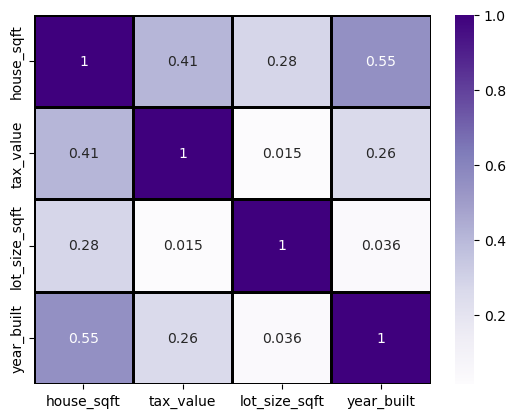

In [121]:
sns.heatmap(train_corr, cmap='Purples', annot=True, linewidth=0.75, 
            linecolor='black',)

In [122]:
train_corr2 = train[cat_var].corr(method='spearman')
train_corr2

,bedrooms,bathrooms
bedrooms,1.000000,0.606556
bathrooms,0.606556,1.000000


<AxesSubplot:>

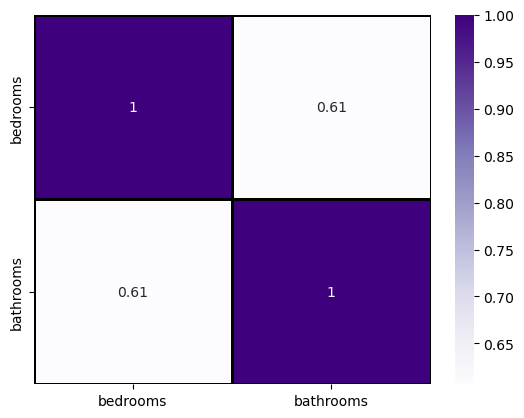

In [123]:
sns.heatmap(train_corr2, cmap='Purples', annot=True, linewidth=0.75, linecolor='black')

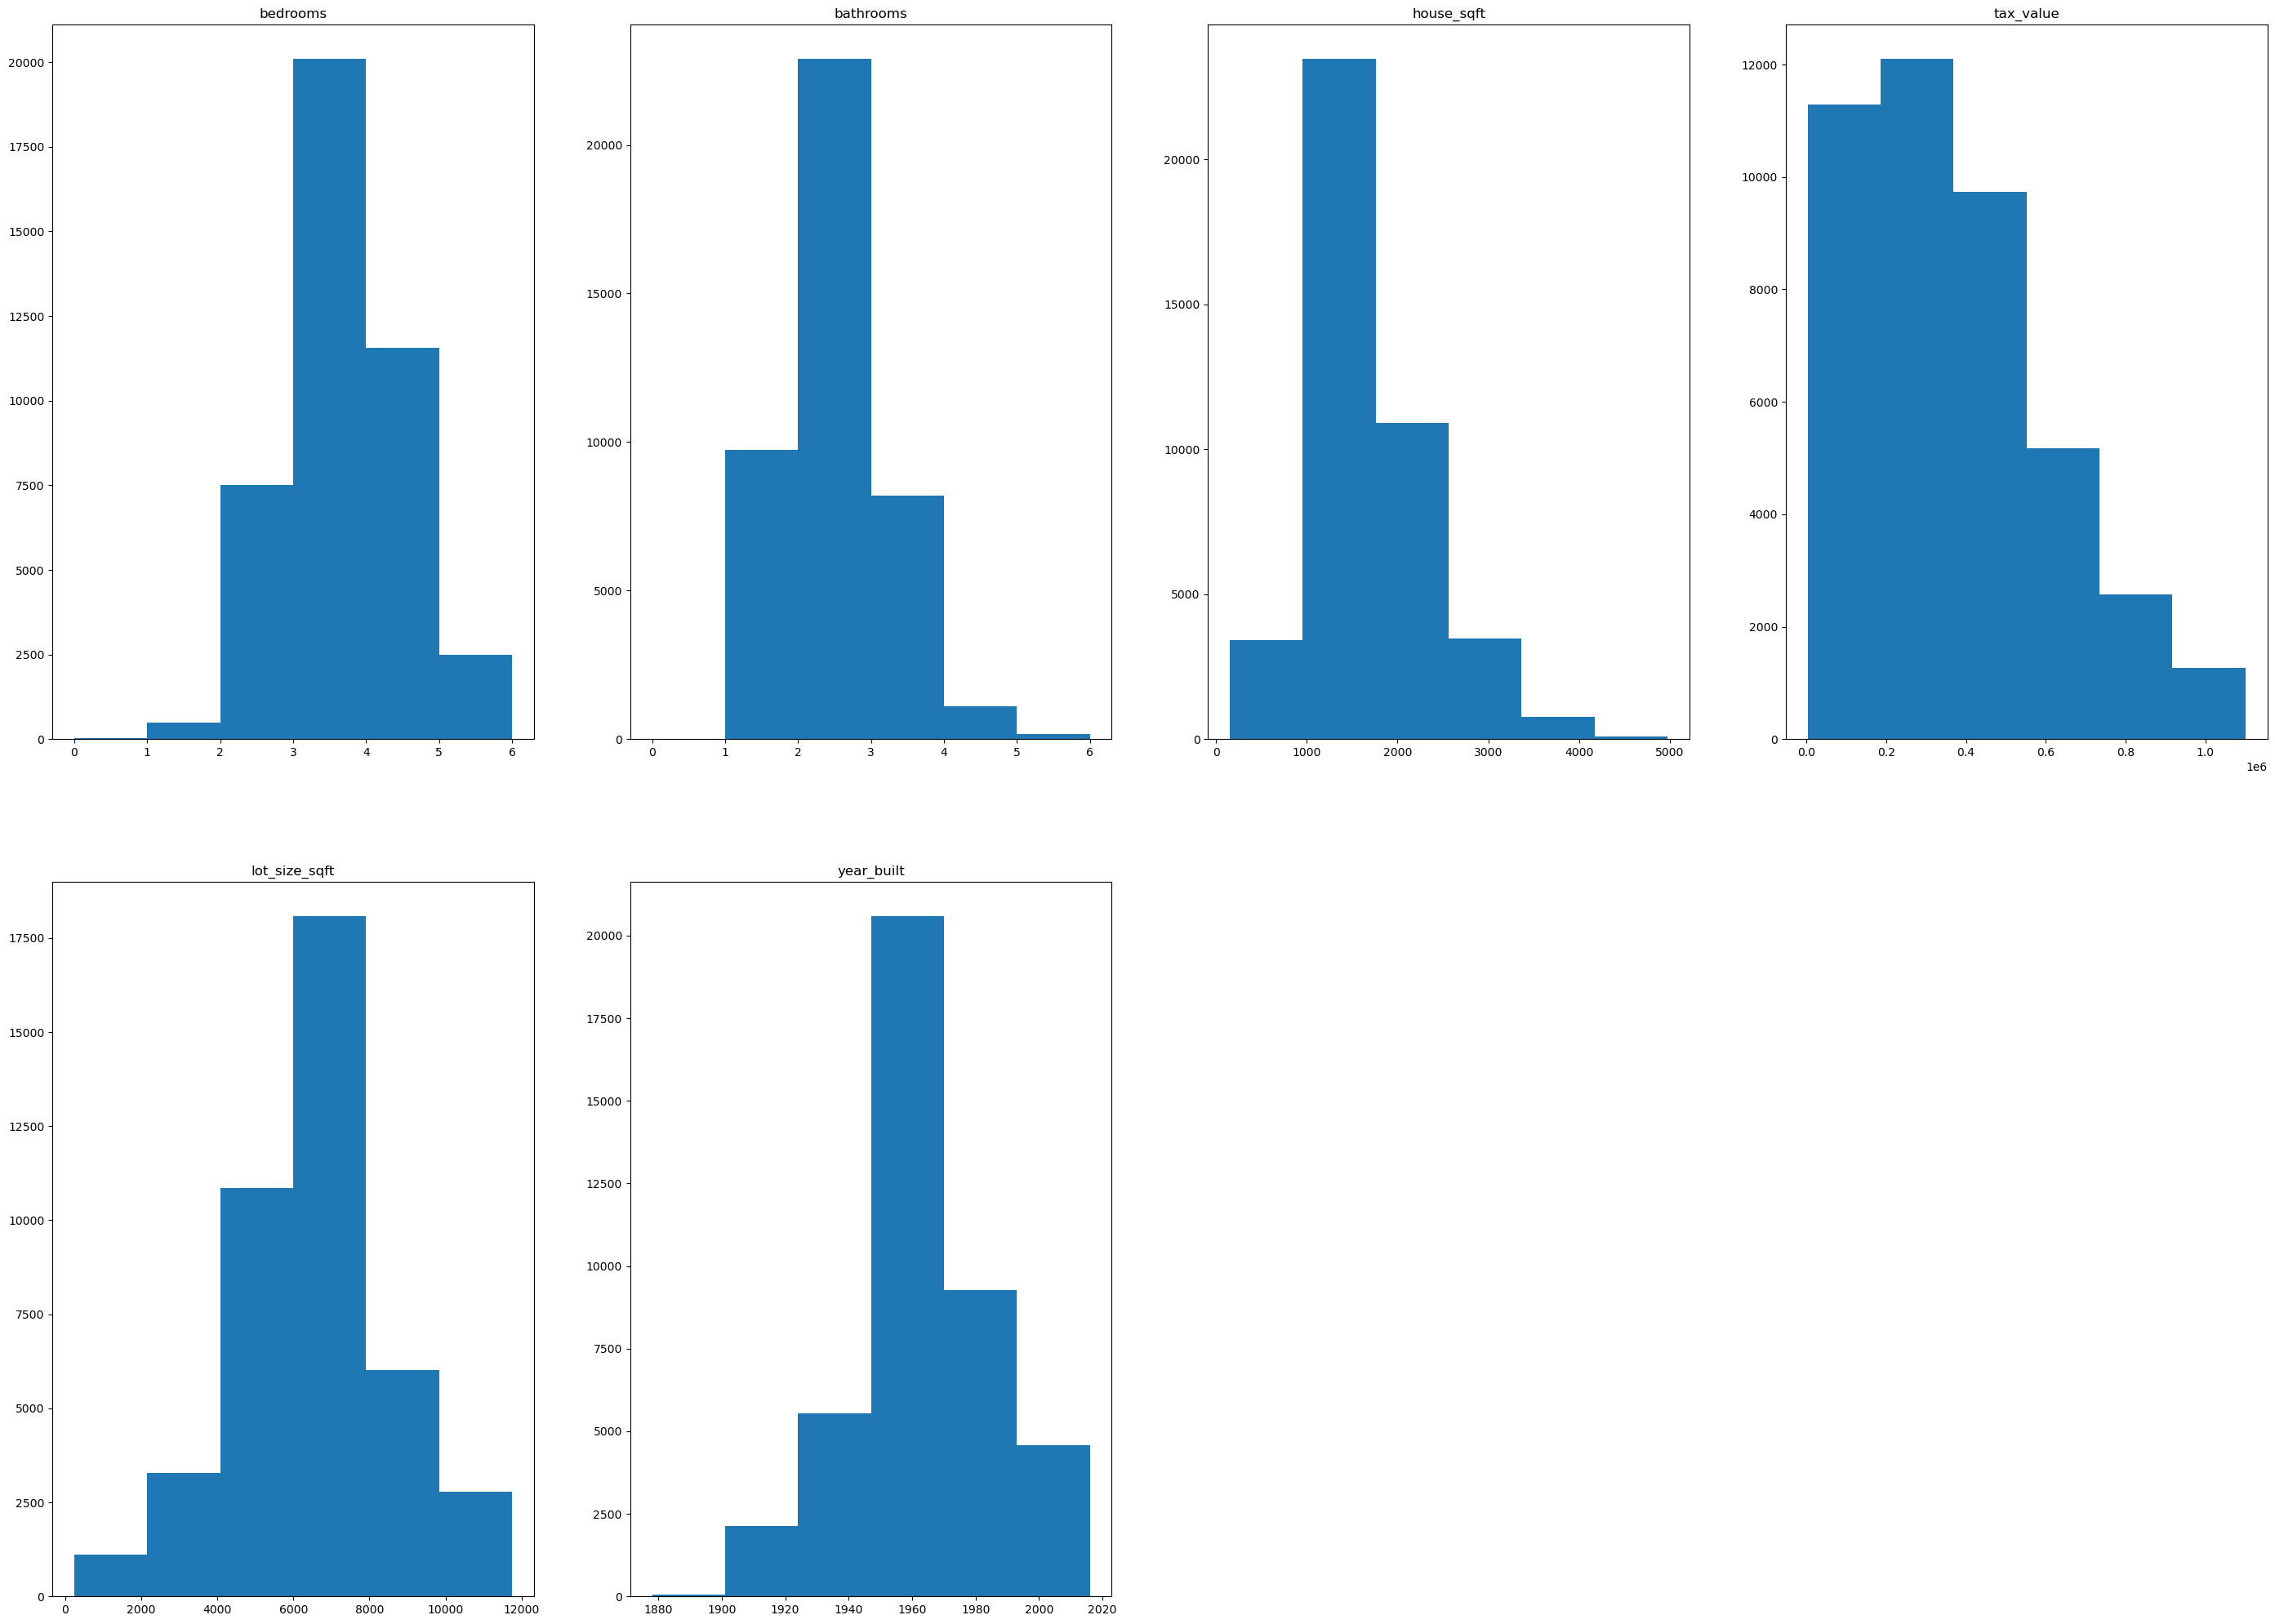

In [124]:
plt.figure(figsize=(35, 25))

# List of columns
cols = ['bedrooms', 'bathrooms', 'house_sqft', 'tax_value', 'lot_size_sqft','year_built']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=6)

    # Hide gridlines.
    plt.grid(False)

# Exploration Summary

<br>
- 
- 
-  


# Modeling
<br>

- I ran the Decision Tree, Random Forest, KNN, and Logistic Regression algorithms to see what fit the data best .

- The evaluation metric used was accuracy, as I wanted to focus on accuracy over the other metrics.

- The basline accuracy is calculated by finding the outcome that occurs most frequent and create a column. You then divide the mean of the baseline column.



In [96]:
# code to generate baseline 
train['tax_value'].value_counts().idxmax()
#train['baseline'] = 
#(train['churn_Yes'] == train['baseline']).mean()
# clean f string
#print(f"Baseline: {(train['tax_value'] == train['baseline']).mean()*100:.2f}%")

450000